***ALL LIBRARY***

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import torch
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from kmeans_pytorch import kmeans


In [93]:
# Check for CUDA availability (i.e., GPU)
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")


GPU: NVIDIA GeForce RTX 4060 Laptop GPU is available.


***Data Preprocessing***

In [94]:
#load data
data = pd.read_csv('data/diabetes_data.csv')

#check for missing values
print(data.isnull().sum())

Age                     0
Sex                     0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Stroke                  0
HighBP                  0
Diabetes                0
dtype: int64


In [95]:
#check for duplicates
print(data.duplicated().sum())
#drop duplicates
data.drop_duplicates(inplace=True)
print(data.info())

#show min and max values for each column
print(data.describe())

#display the information of the bmi column
print(data['BMI'].describe())

6672
<class 'pandas.core.frame.DataFrame'>
Index: 64020 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   64020 non-null  float64
 1   Sex                   64020 non-null  float64
 2   HighChol              64020 non-null  float64
 3   CholCheck             64020 non-null  float64
 4   BMI                   64020 non-null  float64
 5   Smoker                64020 non-null  float64
 6   HeartDiseaseorAttack  64020 non-null  float64
 7   PhysActivity          64020 non-null  float64
 8   Fruits                64020 non-null  float64
 9   Veggies               64020 non-null  float64
 10  HvyAlcoholConsump     64020 non-null  float64
 11  GenHlth               64020 non-null  float64
 12  MentHlth              64020 non-null  float64
 13  PhysHlth              64020 non-null  float64
 14  DiffWalk              64020 non-null  float64
 15  Stroke             

encoding for bmi

BMI can be divided into several categories based on standard health guidelines. Here are common categories:

Underweight: BMI < 18.5

Normal weight: BMI 18.5–24.9

Overweight: BMI 25–29.9

Obesity I: BMI 30–34.9

Obesity II: BMI 35–39.9

Obesity III: BMI ≥ 40

In [96]:
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi <= 24.9:
        return 'Normal weight'
    elif 25 <= bmi <= 29.9:
        return 'Overweight'
    elif 30 <= bmi <= 34.9:
        return 'Obesity I'
    elif 35 <= bmi <= 39.9:
        return 'Obesity II'
    else:
        return 'Obesity III'
    
data['BMI'] = data['BMI'].apply(categorize_bmi)

category_encoding = {
    'Underweight': 1,
    'Normal weight': 2,
    'Overweight': 3,
    'Obesity I': 4,
    'Obesity II': 5,
    'Obesity III': 6
}

data['BMI'] = data['BMI'].map(category_encoding)

In [97]:
def categorize_days(days):
    if days == 0:
        return '0 days'
    elif 1 <= days <= 5:
        return '1-5 days'
    elif 6 <= days <= 10:
        return '6-10 days'
    elif 11 <= days <= 15:
        return '11-15 days'
    elif 16 <= days <= 20:
        return '16-20 days'
    elif 21 <= days <= 25:
        return '21-25 days'
    else:
        return '26-30 days'

# Apply the function to categorize MentHlth and PhysHlth
data['MentHlth'] = data['MentHlth'].apply(categorize_days)
data['PhysHlth'] = data['PhysHlth'].apply(categorize_days)

# Encode the categories into numerical values
category_encoding = {
    '0 days': 0,
    '1-5 days': 1,
    '6-10 days': 2,
    '11-15 days': 3,
    '16-20 days': 4,
    '21-25 days': 5,
    '26-30 days': 6
}
data['MentHlth'] = data['MentHlth'].map(category_encoding)
data['PhysHlth'] = data['PhysHlth'].map(category_encoding)

In [98]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
#categorical_cols = data.select_dtypes(include=['object']).columns
ordinal_binary_cols = ['HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'DiffWalk', 'Stroke', 'HighBP', 'Diabetes']

# Imputation strategies
# For numerical data, use median or mean imputation
numerical_imputer = SimpleImputer(strategy='median')
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])

p_data = data.copy()

# Correcting Data Types
for col in ordinal_binary_cols:
    p_data[col] = data[col].astype(int)

# Handling Outliers
def detect_and_cap_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

for col in numerical_cols:
    if col not in ordinal_binary_cols:
        detect_and_cap_outliers(p_data, col)

# Scaling and Normalization
scaler = StandardScaler()
for col in numerical_cols:
    if col not in ordinal_binary_cols:
        p_data[col] = scaler.fit_transform(p_data[[col]])

# Label Encoding
label_encoder = LabelEncoder()
for col in ordinal_binary_cols:
    p_data[col] = label_encoder.fit_transform(p_data[col])

#save preprocessed data
p_data.to_csv('data/preprocessed_data.csv', index=False)

***Dimensionality Reduction***

In [99]:
#load preprocess data
preprocessed_data = pd.read_csv('data/preprocessed_data.csv')
print(preprocessed_data.head())
scaler = StandardScaler()


data_scaler = scaler.fit_transform(preprocessed_data)


        Age       Sex  HighChol  CholCheck       BMI  Smoker  \
0 -1.610595  1.092276         0          1 -0.463571       0   
1  1.185929  1.092276         1          1 -0.463571       1   
2  1.535495  1.092276         0          1 -0.463571       0   
3  0.836364  1.092276         1          1 -0.463571       1   
4 -0.212333 -0.915520         0          1 -0.463571       1   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                     0             1       0        1                  0   
1                     0             0       1        0                  0   
2                     0             1       1        1                  0   
3                     0             1       1        1                  0   
4                     0             1       1        1                  0   

    GenHlth  MentHlth  PhysHlth  DiffWalk  Stroke  HighBP  Diabetes  
0  0.071208  0.434125  2.090103         0       0       1         0  
1  0.071208 

In [100]:
#reduce dimensions to 3
pca = PCA(n_components=3)
pca.fit(data_scaler)
PCA_ds = pca.transform(data_scaler)
PCA_ds = pd.DataFrame(data = PCA_ds, columns = ['PC1', 'PC2', 'PC3'])
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,64020.0,1.562706e-16,1.815578,-4.488502,-1.417813,-0.145914,1.249805,5.747633
PC2,64020.0,-7.103208e-18,1.255279,-3.641600,-0.927067,-0.099278,0.838050,5.032572
PC3,64020.0,-6.659257e-18,1.146511,-4.031051,-0.841009,0.126428,0.935693,2.867067


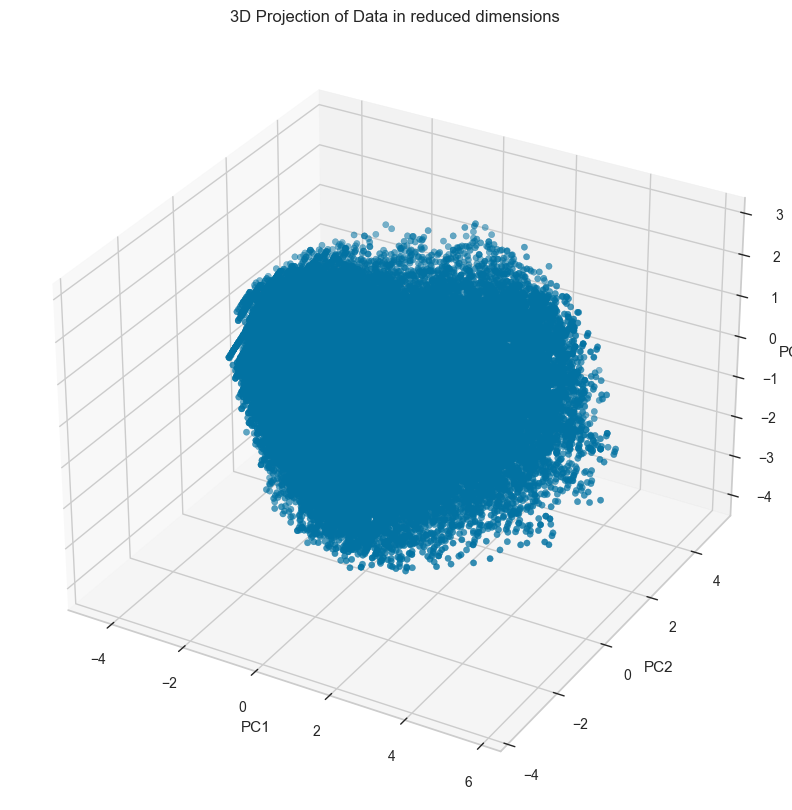

In [101]:
#3D Projection of Data in reduced dimensions
x = PCA_ds['PC1']
y = PCA_ds['PC2']
z = PCA_ds['PC3']

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_title('3D Projection of Data in reduced dimensions')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

***Clustering***

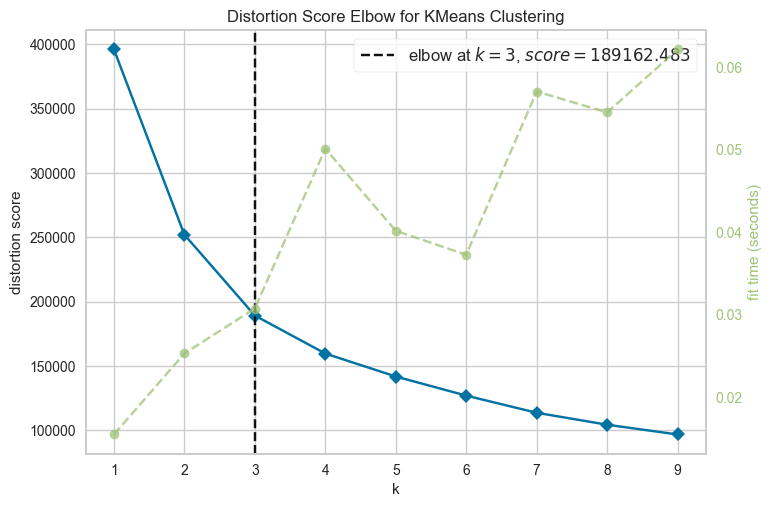

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [102]:
#quick check of elbow method to determine number of clusters
Rlbow_M = KElbowVisualizer(KMeans(), k=(1,10))
Rlbow_M.fit(PCA_ds)
Rlbow_M.show()

3 cluster

In [103]:
# Assuming PCA_ds is a NumPy array or a PyTorch tensor containing your dataset
PCA_ds_numpy = PCA_ds.to_numpy()
# Convert PCA_ds to a PyTorch tensor if it isn't already one
PCA_ds_tensor = torch.tensor(PCA_ds_numpy, dtype=torch.float)

# Specify the number of clusters
num_clusters = 3

# Perform k-means clustering
cluster_ids_x, cluster_centers = kmeans(
    X=PCA_ds_tensor, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:0')
)

# Add the cluster IDs to your dataset
PCA_ds['Clusters'] = cluster_ids_x.cpu().numpy()
data = pd.DataFrame(data)
data['Clusters'] = cluster_ids_x.cpu().numpy()

running k-means on cuda:0..


[running kmeans]: 18it [00:00, 169.79it/s, center_shift=0.000084, iteration=18, tol=0.000100]


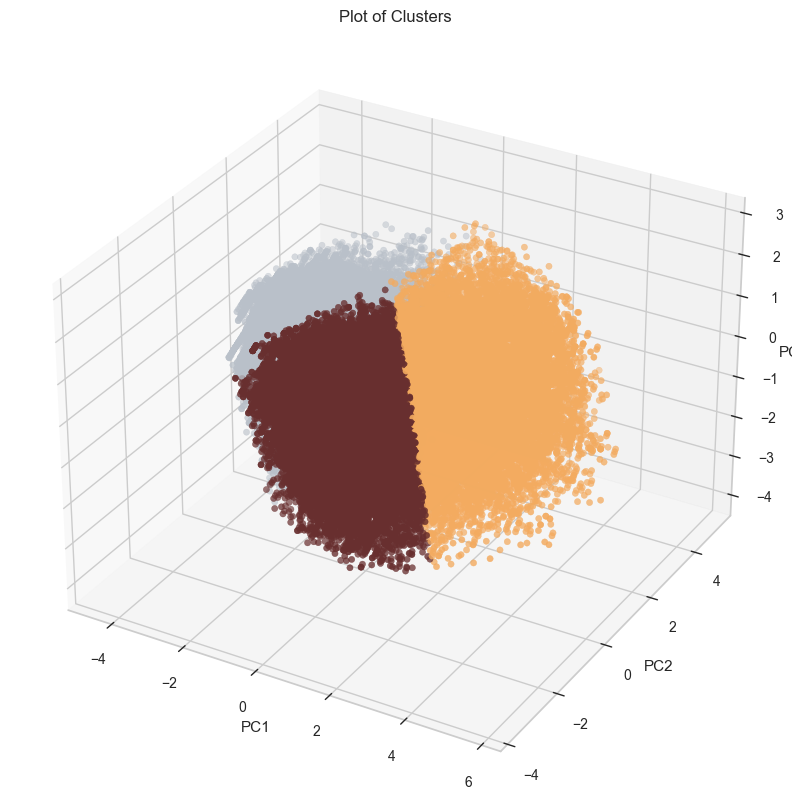

In [104]:
from matplotlib import colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

fig = plt.figure(figsize = (10,10))
ax = plt.subplot(111, projection='3d', label='Cluster')
ax.scatter(x,y,z, c=data['Clusters'], marker='o', cmap=cmap)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Plot of Clusters')
plt.show()

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1859745431.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette= pal)
C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1859745431.py:3: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  pl = sns.countplot(x=data["Clusters"], palette= pal)


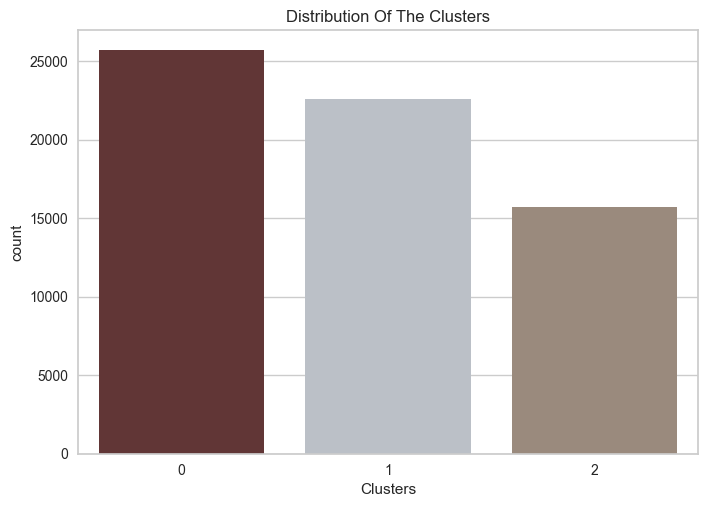

In [105]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [106]:
#print info data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 64020 entries, 0 to 70691
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   64020 non-null  float64
 1   Sex                   64020 non-null  float64
 2   HighChol              64020 non-null  float64
 3   CholCheck             64020 non-null  float64
 4   BMI                   64020 non-null  float64
 5   Smoker                64020 non-null  float64
 6   HeartDiseaseorAttack  64020 non-null  float64
 7   PhysActivity          64020 non-null  float64
 8   Fruits                64020 non-null  float64
 9   Veggies               64020 non-null  float64
 10  HvyAlcoholConsump     64020 non-null  float64
 11  GenHlth               64020 non-null  float64
 12  MentHlth              64020 non-null  float64
 13  PhysHlth              64020 non-null  float64
 14  DiffWalk              64020 non-null  float64
 15  Stroke                64

***Cluster Evaluate***

<Figure size 1500x1000 with 0 Axes>

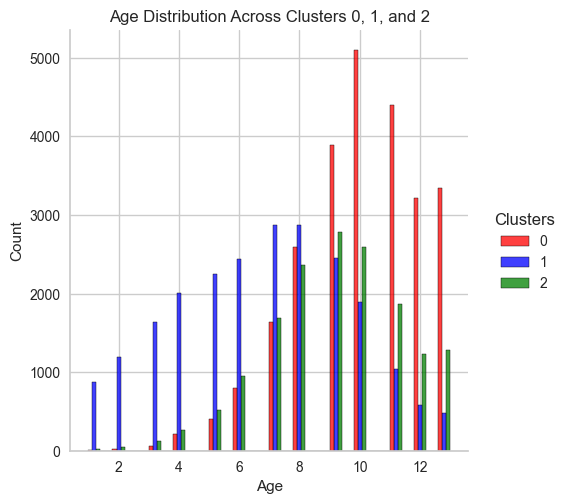

Cluster 0 Age Statistics:
count    25688.000000
mean         9.988827
std          2.085006
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         13.000000
Name: Age, dtype: float64

Cluster 1 Age Statistics:
count    22600.000000
mean         6.679823
std          2.921856
min          1.000000
25%          4.000000
50%          7.000000
75%          9.000000
max         13.000000
Name: Age, dtype: float64

Cluster 2 Age Statistics:
count    15732.000000
mean         9.120900
std          2.285486
min          1.000000
25%          8.000000
50%          9.000000
75%         11.000000
max         13.000000
Name: Age, dtype: float64



C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\245458603.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Clusters', y='Age', data=data, palette=['red', 'blue', 'green'])


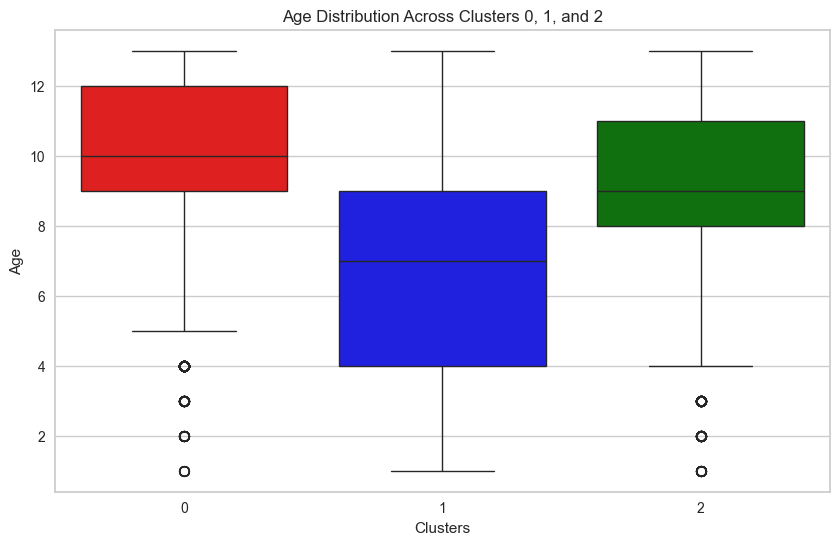

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure for plotting
plt.figure(figsize=(15, 10))

# Use displot with kind='hist' and multiple='dodge' to place bars side by side
sns.displot(data, x='Age', hue='Clusters', kind='hist', palette=['red', 'blue', 'green'], multiple='dodge', bins=30)

# Add a title to the plot
plt.title('Age Distribution Across Clusters 0, 1, and 2')

# Show the plot
plt.show()

# Print the age distribution statistics for each cluster
for i in range(3):
    print(f"Cluster {i} Age Statistics:")
    print(data[data['Clusters'] == i]['Age'].describe())
    print()  # Add an empty line for better readability

plt.figure(figsize=(10, 6))
sns.boxplot(x='Clusters', y='Age', data=data, palette=['red', 'blue', 'green'])
plt.title('Age Distribution Across Clusters 0, 1, and 2')
plt.show()

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\3810601468.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Clusters', y='BMI', data=data, palette=['red', 'blue', 'green'])


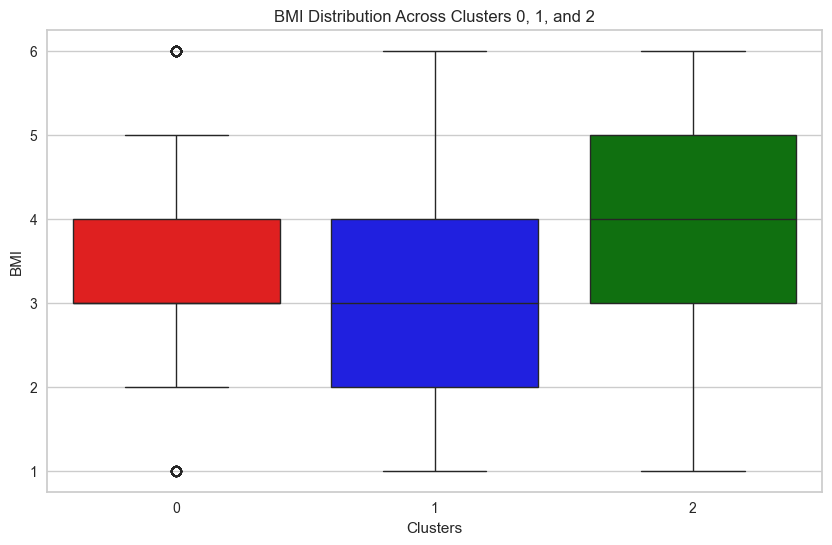

In [108]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Clusters', y='BMI', data=data, palette=['red', 'blue', 'green'])
plt.title('BMI Distribution Across Clusters 0, 1, and 2')
plt.show()

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\2158793936.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p9 = sns.countplot(x="Clusters", hue='Sex', data=data, palette=pal)


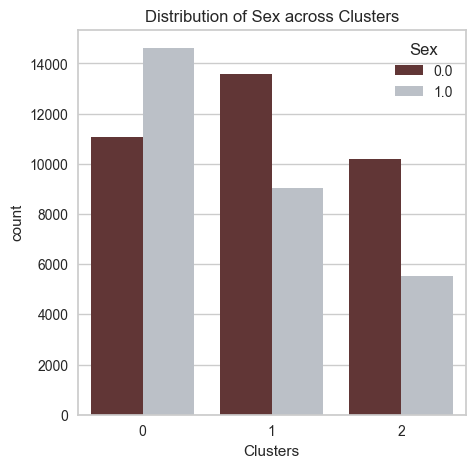

In [109]:
#distribution of sex across clusters barplot
fig = plt.figure(figsize=(5,5))
p9 = sns.countplot(x="Clusters", hue='Sex', data=data, palette=pal)
p9.set_title("Distribution of Sex across Clusters")
plt.show()

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1077304439.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p10 = sns.countplot(x='Clusters', hue='Diabetes', data=data, palette=pal)


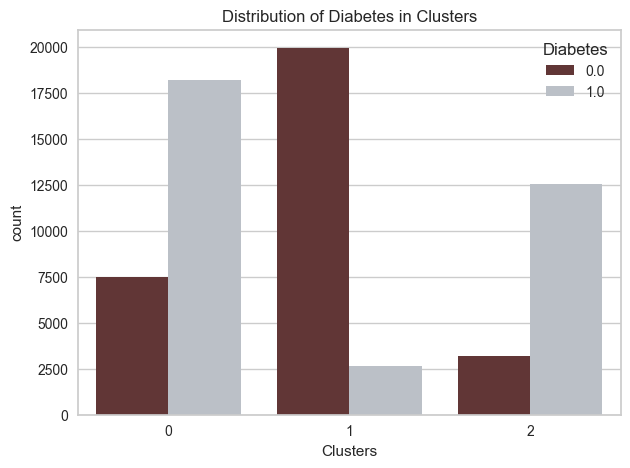

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1077304439.py:8: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p11 = sns.countplot(x='Clusters', hue='HighBP', data=data, palette=pal)


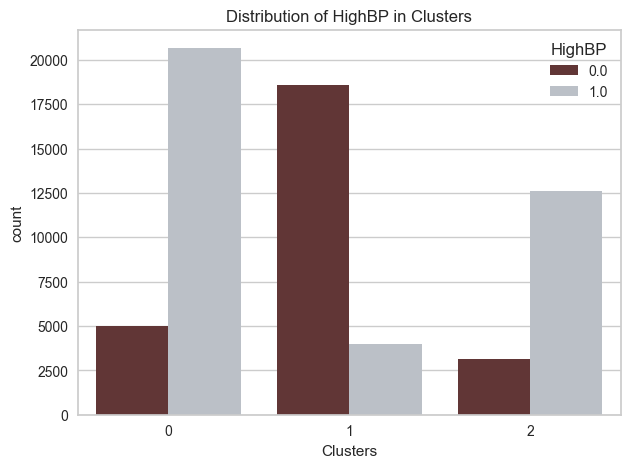

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1077304439.py:13: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p12 = sns.countplot(x='Clusters', hue='Stroke', data=data, palette=pal)


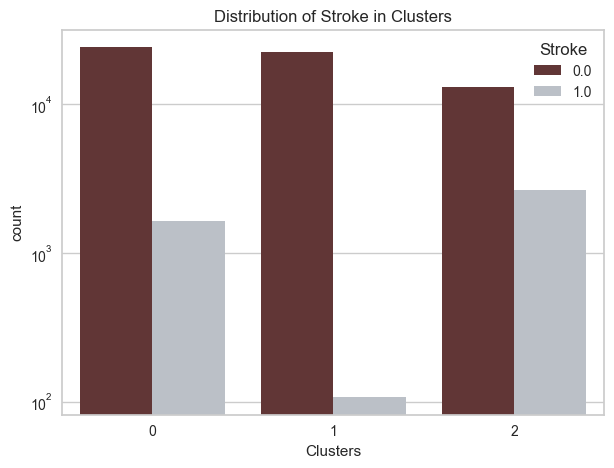

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1077304439.py:19: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p13 = sns.countplot(x='Clusters', hue='HighChol', data=data, palette=pal)


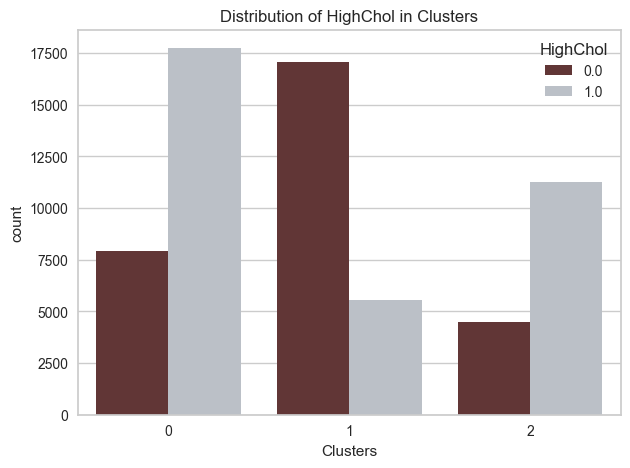

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1077304439.py:25: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p14 = sns.countplot(x='Clusters', hue='HeartDiseaseorAttack', data=data, palette=pal)


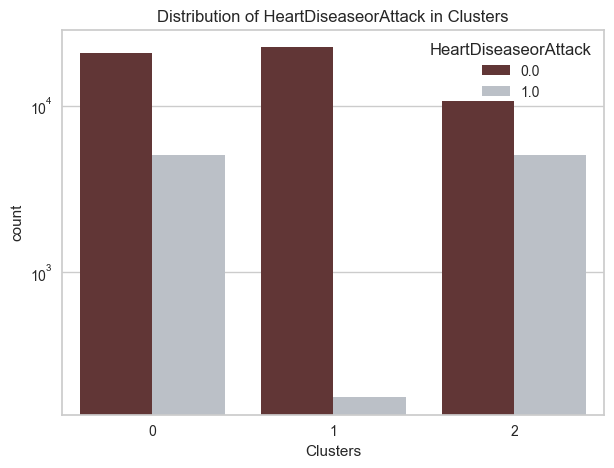

In [138]:
#distribution of diabetes, highbp, stroke, hjighchol, heartdiseaseorattack in clusters in same barplot
fig = plt.figure(figsize=(7,5))
p10 = sns.countplot(x='Clusters', hue='Diabetes', data=data, palette=pal)
p10.set_title('Distribution of Diabetes in Clusters')
plt.show()

fig = plt.figure(figsize=(7,5))
p11 = sns.countplot(x='Clusters', hue='HighBP', data=data, palette=pal)
p11.set_title('Distribution of HighBP in Clusters')
plt.show()

fig = plt.figure(figsize=(7,5))
p12 = sns.countplot(x='Clusters', hue='Stroke', data=data, palette=pal)
p12.set_title('Distribution of Stroke in Clusters')
plt.yscale('log')  # Use log scale
plt.show()

fig = plt.figure(figsize=(7,5))
p13 = sns.countplot(x='Clusters', hue='HighChol', data=data, palette=pal)
p13.set_title('Distribution of HighChol in Clusters')
plt.show()

# Create the countplot
fig = plt.figure(figsize=(7,5))
p14 = sns.countplot(x='Clusters', hue='HeartDiseaseorAttack', data=data, palette=pal)
p14.set_title('Distribution of HeartDiseaseorAttack in Clusters')
plt.yscale('log')  # Use log scale
plt.show()


C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1681130527.py:3: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p15 = sns.countplot(x='Clusters', hue='PhysActivity', data=data, palette=pal)


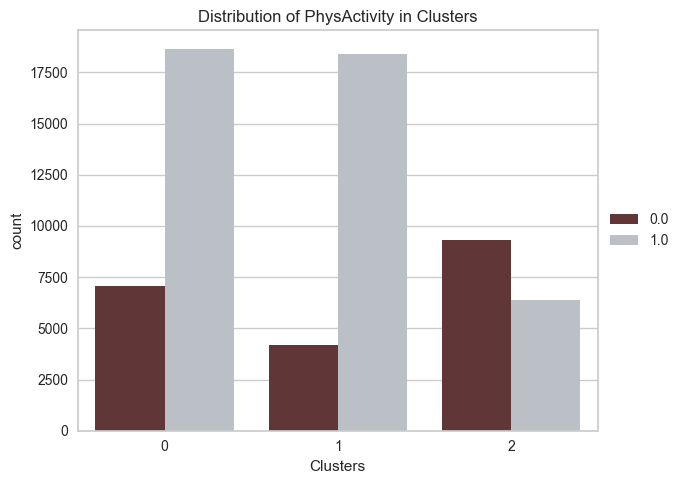

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1681130527.py:10: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p16 = sns.countplot(x='Clusters', hue='Fruits', data=data, palette=pal)


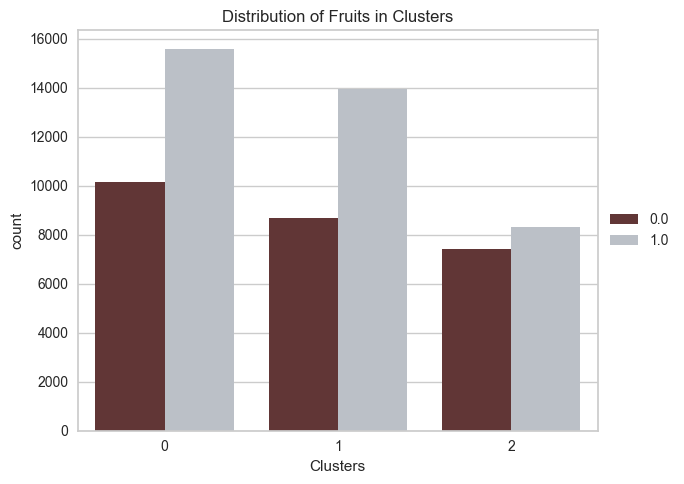

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1681130527.py:17: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p17 = sns.countplot(x='Clusters', hue='Veggies', data=data, palette=pal)


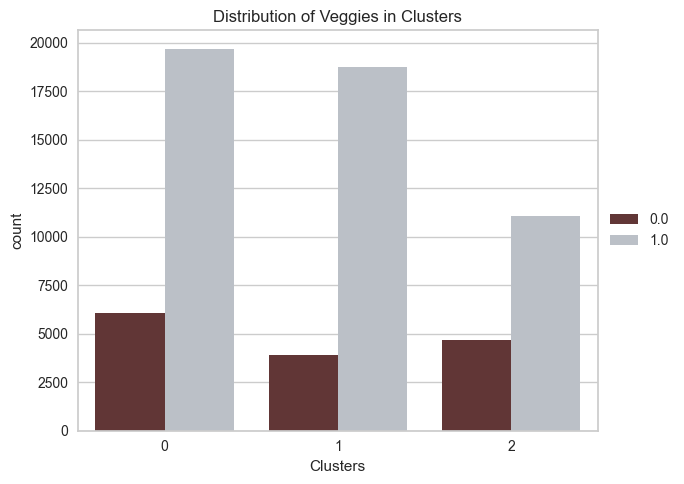

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1681130527.py:25: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p18 = sns.countplot(x='Clusters', hue='HvyAlcoholConsump', data=data, palette=pal)


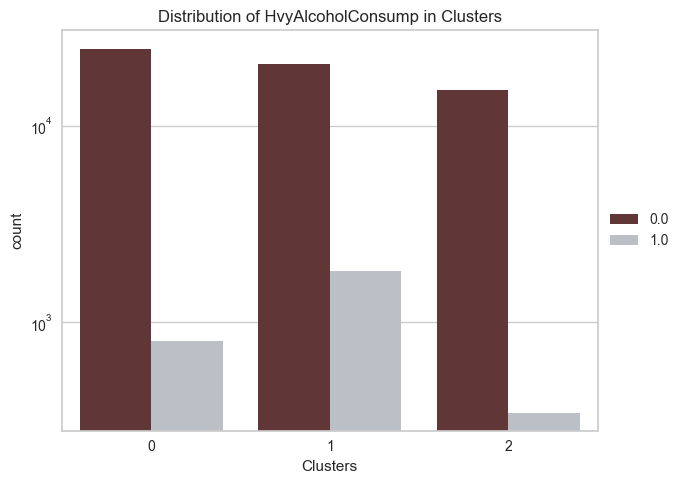

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\1681130527.py:36: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p19 = sns.countplot(x='Clusters', hue='Smoker', data=data, palette=pal)


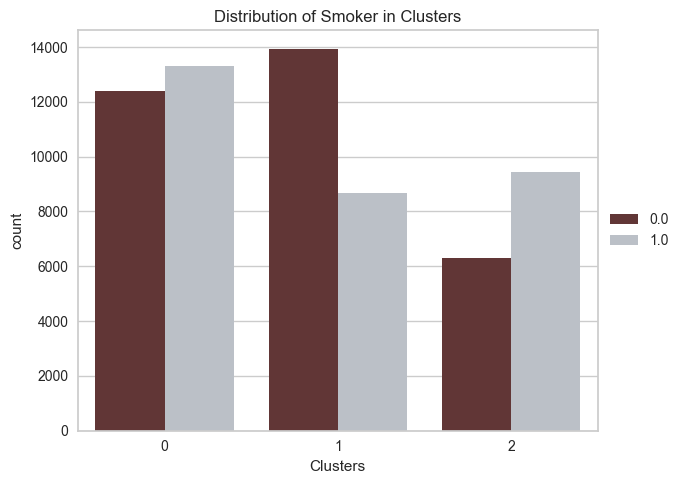

In [115]:
#distribution of PhysActivity	Fruits	Veggies	HvyAlcoholConsump Smoker across clusters
fig = plt.figure(figsize=(7,5))
p15 = sns.countplot(x='Clusters', hue='PhysActivity', data=data, palette=pal)
p15.set_title('Distribution of PhysActivity in Clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Ensure legend doesn't get cut off
plt.show()

fig = plt.figure(figsize=(7,5))
p16 = sns.countplot(x='Clusters', hue='Fruits', data=data, palette=pal)
p16.set_title('Distribution of Fruits in Clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Ensure legend doesn't get cut off
plt.show()

fig = plt.figure(figsize=(7,5))
p17 = sns.countplot(x='Clusters', hue='Veggies', data=data, palette=pal)
p17.set_title('Distribution of Veggies in Clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Ensure legend doesn't get cut off
plt.show()

fig = plt.figure(figsize=(7,5))
# Create a countplot
p18 = sns.countplot(x='Clusters', hue='HvyAlcoholConsump', data=data, palette=pal)
# Set the title of the plot
p18.set_title('Distribution of HvyAlcoholConsump in Clusters')
# Set the y-axis to logarithmic scale
p18.set_yscale('log')
# Display the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Ensure legend doesn't get cut off
plt.show()

fig = plt.figure(figsize=(7,5))
p19 = sns.countplot(x='Clusters', hue='Smoker', data=data, palette=pal)
p19.set_title('Distribution of Smoker in Clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Ensure legend doesn't get cut off
plt.show()

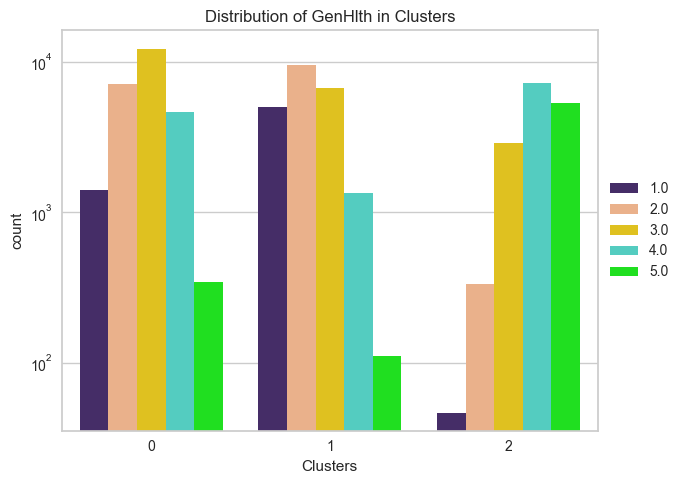

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\2480721136.py:17: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  p21 = sns.countplot(x='Clusters', hue='MentHlth', data=data, palette=palette)


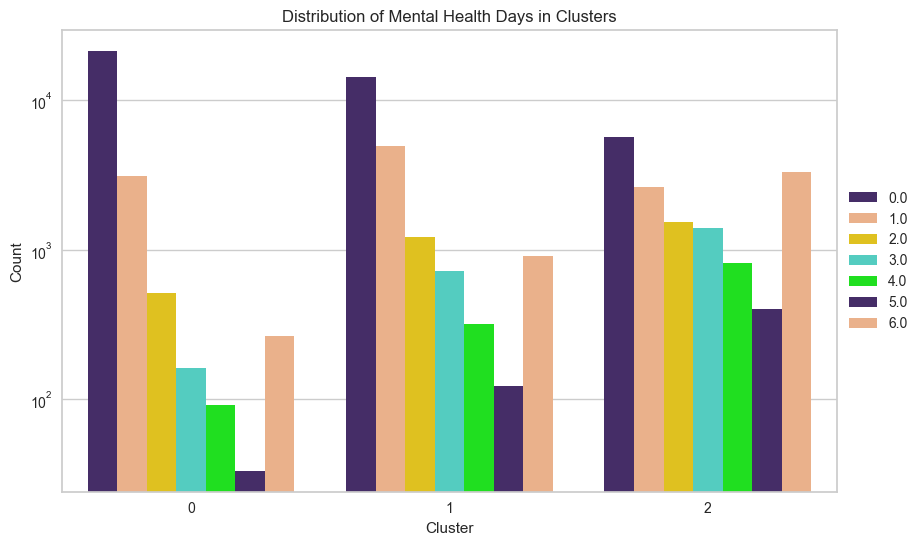

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\2480721136.py:27: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  p22 = sns.countplot(x='Clusters', hue='PhysHlth', data=data, palette=palette)


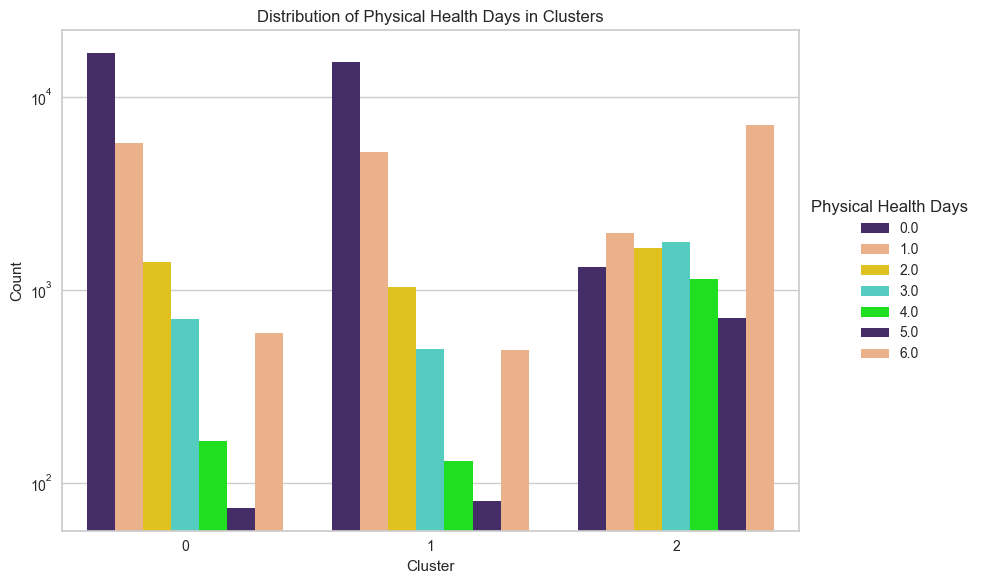

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\2480721136.py:37: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  p23 = sns.countplot(x='Clusters', hue='DiffWalk', data=data, palette=pal)


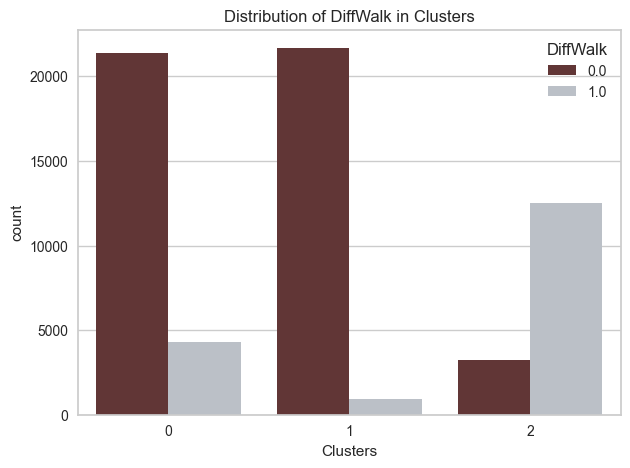

In [135]:
#distribution of GenHlth	MentHlth	PhysHlth	DiffWalk across clusters
palette = ['#432371', '#FAAE7B', '#FFD700', '#40E0D0','#00FF00']  # Add more colors if needed

# Create the countplot
# Create the countplot
fig = plt.figure(figsize=(7,5))
p20 = sns.countplot(x='Clusters', hue='GenHlth', data=data, palette=palette)
p20.set_title('Distribution of GenHlth in Clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')  # Use log scale
plt.tight_layout()  # Ensure legend doesn't get cut off
plt.show()


# Create the countplot
fig = plt.figure(figsize=(10,6))
p21 = sns.countplot(x='Clusters', hue='MentHlth', data=data, palette=palette)
p21.set_title('Distribution of Mental Health Days in Clusters')
p21.set_xlabel('Cluster')
p21.set_ylabel('Count')
plt.legend(title='Mental Health Days')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')  # Use log scale if needed
plt.show()

fig = plt.figure(figsize=(10,6))
p22 = sns.countplot(x='Clusters', hue='PhysHlth', data=data, palette=palette)
p22.set_title('Distribution of Physical Health Days in Clusters')
p22.set_xlabel('Cluster')
p22.set_ylabel('Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Physical Health Days')
plt.yscale('log')  # Use log scale if needed
plt.tight_layout()  # Ensure legend doesn't get cut off
plt.show()

fig = plt.figure(figsize=(7,5))
p23 = sns.countplot(x='Clusters', hue='DiffWalk', data=data, palette=pal)
p23.set_title('Distribution of DiffWalk in Clusters')
plt.show()

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\793523820.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Clusters', y='MentHlth', data=data, palette=['red', 'blue', 'green'])


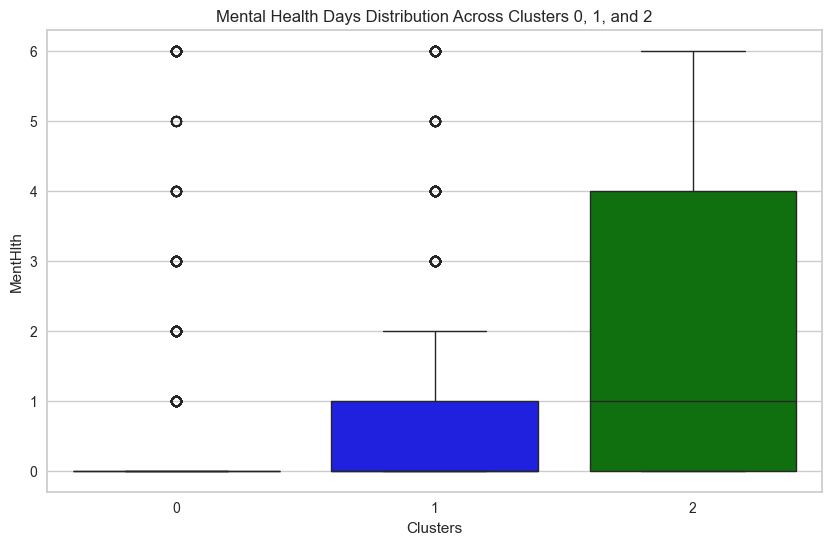

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\793523820.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Clusters', y='PhysHlth', data=data, palette=['red', 'blue', 'green'])


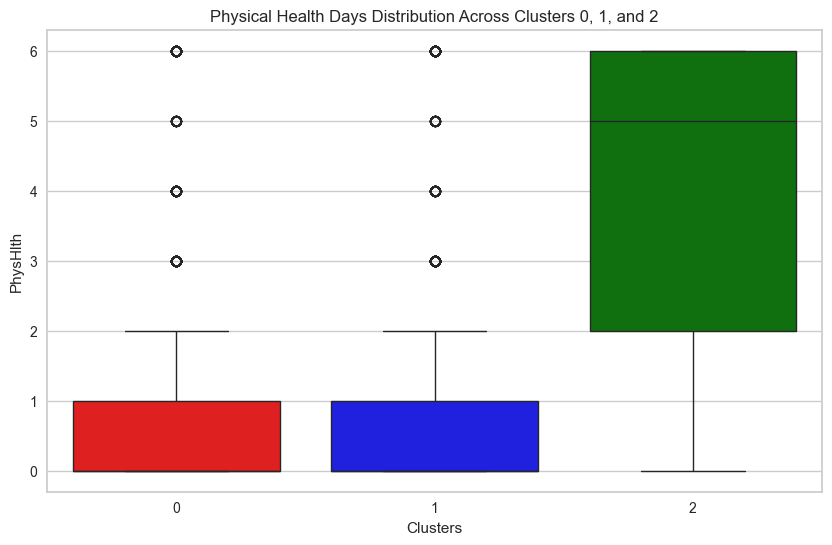

C:\Users\jiach\AppData\Local\Temp\ipykernel_44120\793523820.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Clusters', y='GenHlth', data=data, palette=['red', 'blue', 'green'])


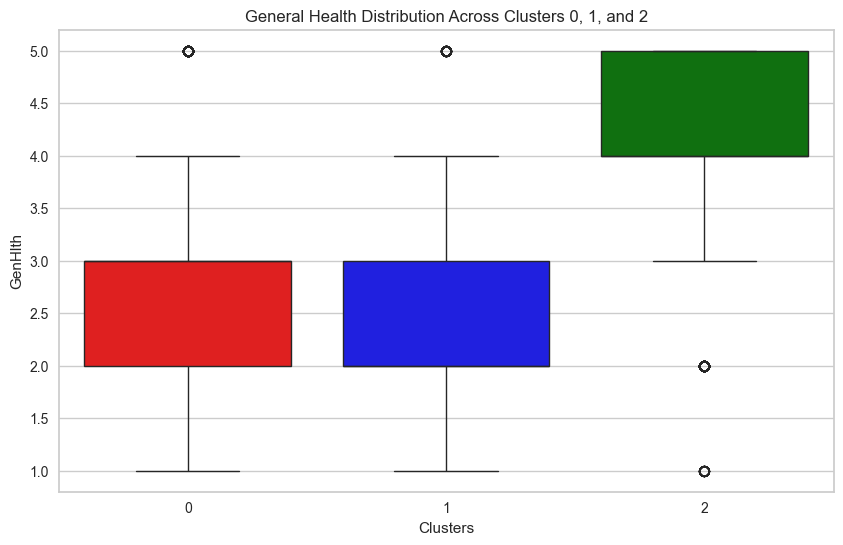

In [136]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Clusters', y='MentHlth', data=data, palette=['red', 'blue', 'green'])
plt.title('Mental Health Days Distribution Across Clusters 0, 1, and 2')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Clusters', y='PhysHlth', data=data, palette=['red', 'blue', 'green'])
plt.title('Physical Health Days Distribution Across Clusters 0, 1, and 2')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Clusters', y='GenHlth', data=data, palette=['red', 'blue', 'green'])
plt.title('General Health Distribution Across Clusters 0, 1, and 2')
plt.show()